# Llama2模型使用

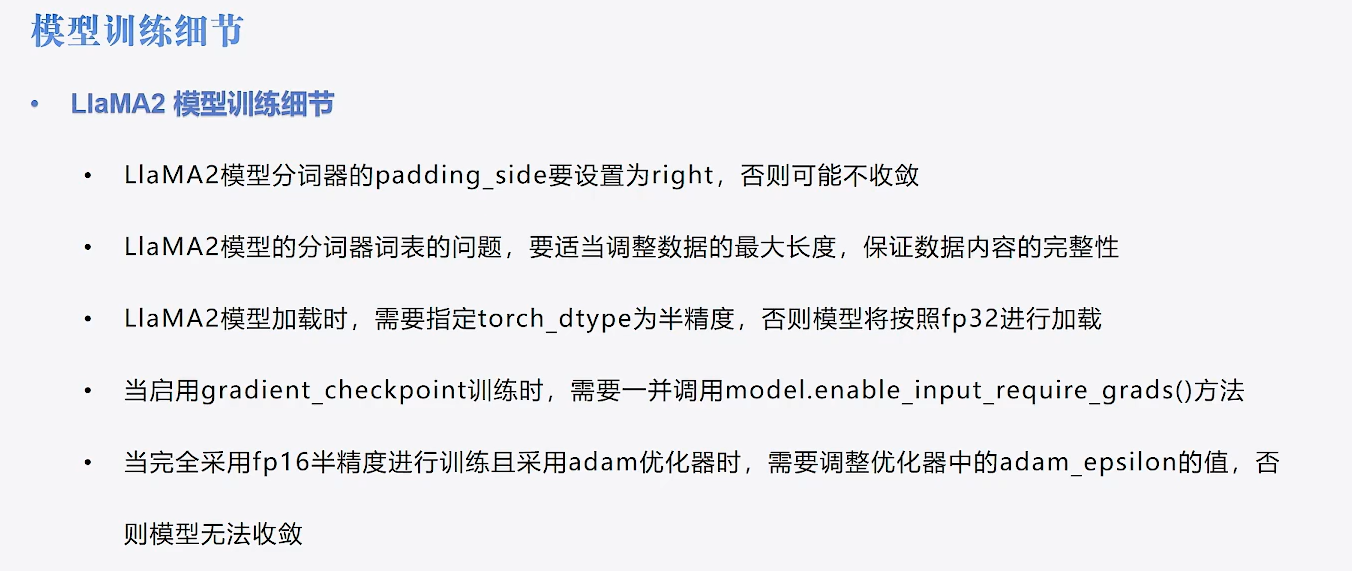

中文的一个经典的项目就是崔一鸣的Chinese-LLaMA-Alpaca

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7'

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
ds = Dataset.load_from_disk("../data/alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

## 加载tokenizer

In [3]:
model_path = "/data1/zhengnanyan/huggingface/modelscope/Llama-2-7b-ms"
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.padding_side='right' # 一定要设置padding_side为right，否则batch大于1时可能不收敛
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = 2
# tokenizer.padding_side = "right"

In [4]:
tokenizer

LlamaTokenizerFast(name_or_path='/data1/zhengnanyan/huggingface/modelscope/Llama-2-7b-ms', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	32000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
}

In [8]:
def process_func(dataset):
    MAX_LENGTH = 384 #原256, # Llama分词器会将一个中文字切分为多个token，因此需要放开一些最大长度，保证数据的完整性
    input_ids, attention_mask, labels = [],[],[]
    instruction = tokenizer('\n'.join(['Human: '+dataset['instruction'], dataset['input']]).strip() + "\n\nAssistant: ",add_special_tokens=False)
    response = tokenizer(dataset['output'] + tokenizer.eos_token,add_special_tokens=False)
    # tokenizer之后的数据
    input_ids = instruction['input_ids']+response['input_ids']
    attention_mask = instruction['attention_mask']+response['attention_mask']
    labels = [-100]*len(instruction['input_ids'])+response['input_ids']
    if len(input_ids) > MAX_LENGTH:
        # 截断
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    # 结果返回
    return {
        "input_ids":input_ids,
        "attention_mask":attention_mask,
        "labels":labels,
    }

In [9]:
tokenized_ds = ds.map(process_func,remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [11]:
print(tokenized_ds[0]['input_ids'])

[12968, 29901, 29871, 30982, 31695, 31863, 31577, 30210, 30457, 30502, 31302, 30858, 30267, 13, 13, 7900, 22137, 29901, 29871, 29871, 30651, 30557, 30392, 30982, 31695, 31863, 31577, 30210, 30457, 30502, 31302, 30858, 30383, 13, 13, 29896, 29889, 29871, 30982, 31695, 31687, 30988, 31704, 30846, 30267, 31951, 30408, 232, 132, 157, 236, 131, 133, 30948, 30210, 31687, 30988, 31894, 30846, 30214, 30847, 233, 152, 166, 233, 176, 168, 30330, 235, 186, 148, 233, 176, 168, 31391, 233, 187, 187, 233, 182, 182, 30214, 30815, 231, 194, 134, 31174, 30869, 235, 164, 131, 31624, 31863, 31577, 30214, 232, 165, 161, 232, 191, 189, 235, 133, 143, 235, 133, 140, 31074, 31180, 30214, 31666, 30417, 31931, 30909, 232, 138, 146, 31022, 30988, 30908, 30267, 13, 13, 29906, 29889, 29871, 232, 160, 138, 235, 164, 164, 236, 168, 177, 31855, 30267, 31951, 30408, 31855, 30406, 30374, 236, 181, 159, 30210, 235, 151, 175, 31854, 30330, 30716, 30801, 30330, 30753, 31112, 30834, 30503, 235, 135, 133, 235, 133, 173, 23

### eos_token问题

发现没有代表</s>的数字token2，因为tokenizer把eos token切碎了

In [13]:
tokenizer.eos_token

'</s>'

In [14]:
# tokenizer单独对eos_token做切分，是没问题的
print(tokenizer(tokenizer.eos_token))

{'input_ids': [1, 2], 'attention_mask': [1, 1]}


In [15]:
# 但是和其他字符放在一起,eos_token就不被切成2了，被切碎了
tokenizer("abc"+tokenizer.eos_token)

{'input_ids': [1, 25638, 829, 29879, 29958], 'attention_mask': [1, 1, 1, 1, 1]}

In [16]:
# 解决方法，加空格
tokenizer("abc "+tokenizer.eos_token)

{'input_ids': [1, 25638, 2], 'attention_mask': [1, 1, 1]}

### 新的数据处理process_func

In [4]:
def process_func(dataset):
    MAX_LENGTH = 384 #原256, # Llama分词器会将一个中文字切分为多个token，因此需要放开一些最大长度，保证数据的完整性
    input_ids, attention_mask, labels = [],[],[]
    instruction = tokenizer('\n'.join(['Human: '+dataset['instruction'], dataset['input']]).strip() + "\n\nAssistant: ",add_special_tokens=False)
    response = tokenizer(dataset['output'],add_special_tokens=False)
    # tokenizer之后的数据
    input_ids = instruction['input_ids']+response['input_ids']+[tokenizer.eos_token_id]
    attention_mask = instruction['attention_mask']+response['attention_mask']+[1] # 加1是eos_token_id也要被看到
    labels = [-100]*len(instruction['input_ids'])+response['input_ids']+[tokenizer.eos_token_id]
    if len(input_ids) > MAX_LENGTH:
        # 截断
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    # 结果返回
    return {
        "input_ids":input_ids,
        "attention_mask":attention_mask,
        "labels":labels,
    }

In [5]:
tokenized_ds = ds.map(process_func,remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [27]:
print(tokenized_ds["input_ids"][0])

[12968, 29901, 29871, 30982, 31695, 31863, 31577, 30210, 30457, 30502, 31302, 30858, 30267, 13, 13, 7900, 22137, 29901, 29871, 29871, 30651, 30557, 30392, 30982, 31695, 31863, 31577, 30210, 30457, 30502, 31302, 30858, 30383, 13, 13, 29896, 29889, 29871, 30982, 31695, 31687, 30988, 31704, 30846, 30267, 31951, 30408, 232, 132, 157, 236, 131, 133, 30948, 30210, 31687, 30988, 31894, 30846, 30214, 30847, 233, 152, 166, 233, 176, 168, 30330, 235, 186, 148, 233, 176, 168, 31391, 233, 187, 187, 233, 182, 182, 30214, 30815, 231, 194, 134, 31174, 30869, 235, 164, 131, 31624, 31863, 31577, 30214, 232, 165, 161, 232, 191, 189, 235, 133, 143, 235, 133, 140, 31074, 31180, 30214, 31666, 30417, 31931, 30909, 232, 138, 146, 31022, 30988, 30908, 30267, 13, 13, 29906, 29889, 29871, 232, 160, 138, 235, 164, 164, 236, 168, 177, 31855, 30267, 31951, 30408, 31855, 30406, 30374, 236, 181, 159, 30210, 235, 151, 175, 31854, 30330, 30716, 30801, 30330, 30753, 31112, 30834, 30503, 235, 135, 133, 235, 133, 173, 23

### 去除bos符号

在tokenizer处理数据时，加上add_special_tokens=False

In [6]:
tokenizer.decode(tokenized_ds["input_ids"][1])
# 注意到，加了<s>符号

'<s> Human: 解释为什么以下分数等同于1/4\n输入：4/16\n\nAssitant: <s> 4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。</s>'

In [10]:
# 要去掉这个<s>符号（bos符号），是llama默认自带的
# 在tokenizer处理数据时，加上add_special_tokens=False
tokenizer.decode(tokenized_ds["input_ids"][1])

'Human: 解释为什么以下分数等同于1/4\n输入：4/16\n\nAssitant:  4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。</s>'

### 文本截断问题

llama的tokenizer词表很小，中文无法被单个token标识，一个中文字符会被标记为多个token，原文本就扩大了几倍

In [12]:
# 还有问题，原ds文本被截断
ds[0]

{'output': '以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
 'input': '',
 'instruction': '保持健康的三个提示。'}

In [13]:
tokenizer.decode(tokenized_ds["input_ids"][0])

'Human: 保持健康的三个提示。\n\nAssitant:  以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重'

In [16]:
# 截断原因
# llama的tokenizer词表很小，中文无法被单个token标识，一个中文字符会被标记为多个token，例如：
tokenizer("呀",add_special_tokens=False)
# “呀”被扩展成4个token，所以原文本被扩张


{'input_ids': [29871, 232, 148, 131], 'attention_mask': [1, 1, 1, 1]}

In [6]:
# 所以扩大process的max_length
tokenizer.decode(tokenized_ds["input_ids"][0])

'Human: 保持健康的三个提示。\n\nAssistant:  以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。</s>'

## 加载模型

In [7]:
import torch
# 创建模型
model = AutoModelForCausalLM.from_pretrained(model_path,
                                             low_cpu_mem_usage=True,
                                             torch_dtype = torch.half,
                                             device_map='auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/data1

In [8]:
model.half() # 开启半精度
model.enable_input_require_grads()

In [9]:
for name,param in model.named_parameters():
    print(name,param.dtype)

model.embed_tokens.weight torch.float16
model.layers.0.self_attn.q_proj.weight torch.float16
model.layers.0.self_attn.k_proj.weight torch.float16
model.layers.0.self_attn.v_proj.weight torch.float16
model.layers.0.self_attn.o_proj.weight torch.float16
model.layers.0.mlp.gate_proj.weight torch.float16
model.layers.0.mlp.up_proj.weight torch.float16
model.layers.0.mlp.down_proj.weight torch.float16
model.layers.0.input_layernorm.weight torch.float16
model.layers.0.post_attention_layernorm.weight torch.float16
model.layers.1.self_attn.q_proj.weight torch.float16
model.layers.1.self_attn.k_proj.weight torch.float16
model.layers.1.self_attn.v_proj.weight torch.float16
model.layers.1.self_attn.o_proj.weight torch.float16
model.layers.1.mlp.gate_proj.weight torch.float16
model.layers.1.mlp.up_proj.weight torch.float16
model.layers.1.mlp.down_proj.weight torch.float16
model.layers.1.input_layernorm.weight torch.float16
model.layers.1.post_attention_layernorm.weight torch.float16
model.layers.2

## Lora

In [9]:
from peft import LoraConfig, TaskType, get_peft_model,prepare_model_for_kbit_training

config = LoraConfig(task_type=TaskType.CAUSAL_LM,)
# prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)


model.print_trainable_parameters()

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


In [10]:
args = TrainingArguments(
    output_dir="./my-llama2",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1,
    save_steps=20,
    gradient_checkpointing=True, # 需要model.enable_input_require_grads()
    adam_epsilon=1e-4 # 和半精度舍入有关
)

In [11]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds.select(range(6000)),
    # tokenizer=tokenizer
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer,padding=True)
)

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [12]:
trainer.train()


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,1.311500
20,1.325400


/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /data1/zhengnanyan/huggingface/modelscope/Llama-2-7b-ms - will assume that the vocabulary was not modified.
  warnings.warn(
/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


KeyboardInterrupt: 

In [21]:
trainer.train() # per_device_train_batch_size=2，需要的显存更大
# loss也很奇怪

Step,Training Loss
10,114008.562500
20,0.000000


KeyboardInterrupt: 

### loss异常的原因

batchsize不一样，会涉及到padding。

问题在tokenizer的padding：padding_side='left', 左侧填充

要指定为right

In [22]:
tokenizer

LlamaTokenizerFast(name_or_path='/data1/zhengnanyan/huggingface/modelscope/Llama-2-7b-ms', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	32000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
}

### 调整padding_side后再次train

In [13]:
trainer.train()

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,121318.837500


KeyboardInterrupt: 

### 溢出问题

半精度训练时，正确加入eos_token后，要将pad_token_id也置为eos_token_id，否则模型通用无法收敛

## 模型推理

In [13]:
from peft import PeftModel

'''
为什么要像下面那样加载：即先加载预训练模型，再加载我们微调的模型——因为使用lora。
lora我们只训练部分参数，多以微调后保存的模型参数无法直接用于加载模型。
要把那一部分参数和base model合并
'''
output_dir="/data1/zhengnanyan/code/transformers-code-master/04-Kbit Training/25-16bits_training/my-llama2/checkpoint-20"
# tokenizer = AutoTokenizer.from_pretrained(output_dir)
# # model_path = "/data1/zhengnanyan/huggingface/modelscope/Llama-2-7b-ms"
# model_path = "/data1/zhengnanyan/huggingface/modelscope/Llama-2-7b-ms"
model = AutoModelForCausalLM.from_pretrained(model_path,device_map='auto')

p_model = PeftModel.from_pretrained(model, model_id=output_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/data1

In [14]:
p_model.eval()
ipt = tokenizer("Human: {}\n{}".format("你好","").strip()+ "\n\nAssistant: ", return_tensors="pt").to(model.device)
tokenizer.decode(model.generate(**ipt, 
                                max_length=128, 
                                do_sample=True,
                                eos_token_id=tokenizer.eos_token_id)[0], 
                 skip_special_tokens=True)

'Human: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\nHuman: 你好\n\nAssistant: 你好\n\n'